In [1]:
!pip install tensorflow==2.11.0
!pip install git+https://github.com/VenkateshwaranB/stellargraph.git

  Obtaining dependency information for tensorflow==2.11.0 from https://files.pythonhosted.org/packages/71/f5/20795b0d2cc65da482ddb1735e630b85ef4916673967ce30a64ecb979303/tensorflow-2.11.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
  Obtaining dependency information for gast<=0.4.0,>=0.2.1 from https://files.pythonhosted.org/packages/b6/48/583c032b79ae5b3daa02225a675aeb673e58d2cb698e78510feceb11958c/gast-0.4.0-py3-none-any.whl.metadata
  Obtaining dependency information for keras<2.12,>=2.11.0 from https://files.pythonhosted.org/packages/de/44/bf1b0eef5b13e6201aef076ff34b91bc40aace8591cd273c1c2a94a9cc00/keras-2.11.0-py2.py3-none-any.whl.metadata
  Obtaining dependency information for protobuf<3.20,>=3.9.2 from https://files.pythonhosted.org/packages/26/ef/bd6ba3b4ff9a35944bdd325e2c9ee56f71e855757f7d43938232499f0278/protobuf-3.19.6-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
  Obtaining dependency information for tensorboard<2.12,>=2.11 fr

In [2]:
import networkx as nx
import pandas as pd
import numpy as np
import os
import random
from scipy.sparse.linalg import eigsh

import stellargraph as sg
from stellargraph.data import EdgeSplitter
from stellargraph.mapper import GraphSAGELinkGenerator
from stellargraph.layer import GraphSAGE, link_classification
from stellargraph.data import UniformRandomWalk
from stellargraph.data import UnsupervisedSampler
from stellargraph.mapper import GraphSAGENodeGenerator
from stellargraph import globalvar
from stellargraph import datasets

from tensorflow import keras
from sklearn import preprocessing, feature_extraction, model_selection
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

import torch
from torch.utils.data import Dataset, DataLoader

2024-05-10 22:42:20.709024: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-10 22:42:20.817206: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-05-10 22:42:20.817227: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2024-05-10 22:42:21.601180: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-

In [3]:
df = pd.read_csv("adjacency.csv")
df1 = pd.read_excel('attributes.xlsx', sheet_name='in')

In [4]:
Gx = nx.from_numpy_array(df.to_numpy())
G = sg.StellarGraph(Gx, node_features=df1)

/tmp/ipykernel_394270/1144633974.py:2: DeprecationWarning: Constructing a StellarGraph directly from a NetworkX graph has been replaced by the `StellarGraph.from_networkx` function
  G = sg.StellarGraph(Gx, node_features=df1)


In [5]:
nodes = list(G.nodes())
number_of_walks = 5
length = 10

In [6]:
unsupervised_samples = UnsupervisedSampler(
    G, nodes=nodes, length=length, number_of_walks=number_of_walks
)

In [7]:
batch_size = 50
epochs = 4
num_samples = [10, 5]

In [8]:
generator = GraphSAGELinkGenerator(G, batch_size, num_samples)
train_gen = generator.flow(unsupervised_samples)

In [9]:
layer_sizes = [50, 50]
graphsage = GraphSAGE(
    layer_sizes=layer_sizes, generator=generator, bias=True, dropout=0.0, normalize="l2"
)

In [10]:
x_inp, x_out = graphsage.in_out_tensors()

/mnt/107201F57201E078/roop-unleashed/installer/installer_files/env/lib/python3.10/site-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


In [11]:
prediction = link_classification(
    output_dim=1, output_act="sigmoid", edge_embedding_method="ip"
)(x_out)

link_classification: using 'ip' method to combine node embeddings into edge embeddings


In [12]:
model = keras.Model(inputs=x_inp, outputs=prediction)

model.compile(
    optimizer=keras.optimizers.Adam(lr=1e-3),
    loss=keras.losses.binary_crossentropy,
    metrics=[keras.metrics.binary_accuracy],
)

In [13]:
history = model.fit(
    train_gen,
    epochs=epochs,
    verbose=1,
    use_multiprocessing=False,
    workers=4,
    shuffle=True,
)

Epoch 1/4
21514/21514 [==============================] - 1604s 74ms/step - loss: 0.6979 - binary_accuracy: 0.5000
Epoch 2/4
21514/21514 [==============================] - 1673s 78ms/step - loss: 0.6969 - binary_accuracy: 0.5004
Epoch 3/4
21514/21514 [==============================] - 1629s 76ms/step - loss: 0.6967 - binary_accuracy: 0.4994
Epoch 4/4
21514/21514 [==============================] - 1663s 77ms/step - loss: 0.6965 - binary_accuracy: 0.5003


In [14]:
x_inp_src = x_inp[0::2]
x_out_src = x_out[0]
embedding_model = keras.Model(inputs=x_inp_src, outputs=x_out_src)

In [15]:
node_gen = GraphSAGENodeGenerator(G, batch_size, num_samples).flow(pd.Index(np.arange(0, 11952)))

In [16]:
node_embeddings = embedding_model.predict(node_gen, workers=4, verbose=1)

240/240 [==============================] - 9s 37ms/step


In [30]:
emb = pd.DataFrame(node_embeddings)

In [18]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(emb)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 11952 samples in 0.002s...
[t-SNE] Computed neighbors for 11952 samples in 0.413s...
[t-SNE] Computed conditional probabilities for sample 1000 / 11952
[t-SNE] Computed conditional probabilities for sample 2000 / 11952
[t-SNE] Computed conditional probabilities for sample 3000 / 11952
[t-SNE] Computed conditional probabilities for sample 4000 / 11952
[t-SNE] Computed conditional probabilities for sample 5000 / 11952
[t-SNE] Computed conditional probabilities for sample 6000 / 11952
[t-SNE] Computed conditional probabilities for sample 7000 / 11952
[t-SNE] Computed conditional probabilities for sample 8000 / 11952
[t-SNE] Computed conditional probabilities for sample 9000 / 11952
[t-SNE] Computed conditional probabilities for sample 10000 / 11952
[t-SNE] Computed conditional probabilities for sample 11000 / 11952
[t-SNE] Computed conditional probabilities for sample 11952 / 11952
[t-SNE] Mean sigma: 0.281014
[t-SNE] KL divergenc

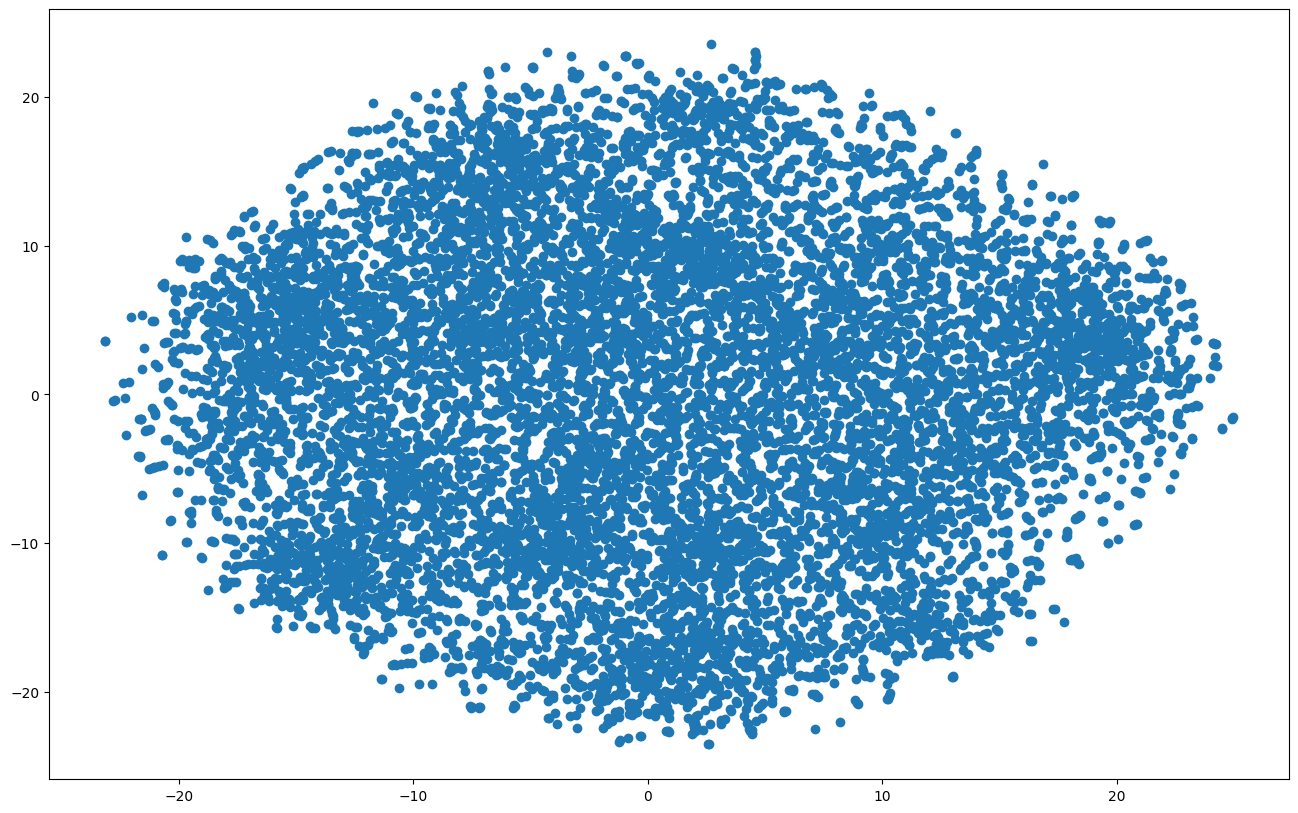

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(16,10))
plt.scatter(tsne_results[:,0], tsne_results[:,1])
plt.show()

In [20]:
best_labels = pd.read_csv('best.csv')

In [22]:
X_train = emb.iloc[:10952, :]
X_test = emb.iloc[10953:, :]

y_train = best_labels['LABEL'].iloc[:10952]
y_test = best_labels['LABEL'].iloc[10953:]

clf = LogisticRegressionCV(cv=5, random_state=0, n_jobs=-1).fit(X_train, y_train)
clf.score(X_test, y_test)

0.34934934934934936